In [508]:
#This Jupyter notebook is a key component of the BEMM466 Business Project, and its contents detail the computational methodology and implementation of our research. The comprehensive project report, which provides a full analysis, discussion of findings, and conclusions, has been submitted separately.
#The data and all necessary project files are accessible through the following shared OneDrive link: https://universityofexeteruk-my.sharepoint.com/:f:/r/personal/ay366_exeter_ac_uk/Documents/BEMM466_Business%20Project?csf=1&web=1&e=eXuZIH

In [ ]:
# --- 0) Imports & Config ---
import os
import math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
)

# === Paths ===
DATA_PATH = Path("tianchi_log_product_merged3.csv")

# === Runtime knobs ===
USE_MINIBATCH = True          # faster KMeans on larger data
K_GRID = list(range(2, 9))    # candidate k values
MAX_SAMPLE_FOR_K = 8000       # subsample users for k-diagnostics (speed)
N_INIT = 10                   # number of centroid initializations
SEEDS = [0, 1, 2, 3, 4]       # for stability checks
RANDOM_STATE = 42

# ============================
# 1) Load merged event-level data
# ============================
usecols = None
df = pd.read_csv(DATA_PATH, usecols=usecols, low_memory=False)



In [510]:
df

,user_id,item_id,behavior,time_stamp,behavior_type,time_col,item_id_clean,title,pic_url,cat_id,merchant_id,brand_id
0,100005,2001865,NaN,NaN,click,2013-05-01 15:46:10,2001865,职业 生涯 规划 ( 中等 职业 教育 课程 改革 国家 规划 新教材 / 柳君芳 姚裕群,http://img01.taobaocdn.com/bao/uploaded/i3/T1o...,35-5194,NaN,"s84707,,,"
1,100005,5670264,NaN,NaN,click,2013-06-12 07:14:37,5670264,百万英镑 / 青少年 文库 ( 美 ) 马克 & middot ; 吐温 | 译者 : ...,http://img01.taobaocdn.com/bao/uploaded/i1/165...,35-4832,NaN,"s34399,,,"
2,100005,346615,NaN,NaN,click,2013-07-27 21:23:32,346615,玫瑰 百合 花篮 上海 花店 | 浦东 花店 | 上海 鲜花速递 | 上海 生日花篮,http://img01.taobaocdn.com/bao/uploaded/i6/T1k...,52-5240,b17504,"s29027,,,"
3,100005,6354293,NaN,NaN,click,2013-08-13 20:34:22,6354293,正品包邮 美国 Patrick 帕特里克 VL 100 入门 初学 初级 专业 考级 小提琴,http://img01.taobaocdn.com/bao/uploaded/i3/100...,40-6027,b38928,"s35565,,,"
4,1000170,5693441,NaN,NaN,click,2013-05-02 22:18:43,5693441,正版 * 优秀 青少年 科普 趣味 读物 丛书 & bull ; 人类 奥秘 978...,http://img01.taobaocdn.com/bao/uploaded/i4/185...,35-6403,NaN,"s4568,,,"
...,...,...,...,...,...,...,...,...,...,...,...,...
188165,999876,6130816,NaN,NaN,click,2013-06-23 15:43:00,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,"s79957,,,"
188166,999876,6130816,NaN,NaN,click,2013-08-14 20:42:42,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,"s79957,,,"
188167,999876,6130816,NaN,NaN,click,2013-08-14 20:43:51,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,"s79957,,,"
188168,999876,4567142,NaN,NaN,click,2013-09-27 08:04:29,4567142,怀素 大 草 千字文 商城 正版,http://img01.taobaocdn.com/bao/uploaded/i2/148...,35-4045,NaN,"s1963,,,"


In [512]:
# ---------- Cleaning & normalization ----------
# Required columns
# Keep the columns we need
expected_cols = {
    "user_id", "behavior_type", "time_col"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")


# Drop rows with missing key fields
df = df.dropna(subset=["user_id", "behavior_type", "time_col"])

# Parse time (keep only valid timestamps)
df["time"] = pd.to_datetime(df["time_col"], errors="coerce")
df = df.dropna(subset=["time"])

# Normalize behavior labels → click/cart/fav/buy
bt_map = {"click": "click", "cart": "cart","collect": "fav", "alipay": "buy"}
df["behavior_type"] = df["behavior_type"].astype(str).str.strip().str.lower()
df["behavior_type"] = df["behavior_type"].map(bt_map)

# Keep only known behaviors
df = df[df["behavior_type"].isin(["click", "cart", "fav", "buy"])]

# Remove empty columns ("behavior", "time_stamp") and dupilcate column ("item_id")
df = df.drop(columns=["behavior", "time_stamp", "item_id"], errors="ignore")

# Remove extra comma from column "brand_id"
df["brand_id"] = df["brand_id"].str.replace(r",+$", "", regex=True)

# Remove exact duplicate rows (same event recorded twice)
df = df.drop_duplicates()


In [514]:
df

,user_id,behavior_type,time_col,item_id_clean,title,pic_url,cat_id,merchant_id,brand_id,time
0,100005,click,2013-05-01 15:46:10,2001865,职业 生涯 规划 ( 中等 职业 教育 课程 改革 国家 规划 新教材 / 柳君芳 姚裕群,http://img01.taobaocdn.com/bao/uploaded/i3/T1o...,35-5194,NaN,s84707,2013-05-01 15:46:10
1,100005,click,2013-06-12 07:14:37,5670264,百万英镑 / 青少年 文库 ( 美 ) 马克 & middot ; 吐温 | 译者 : ...,http://img01.taobaocdn.com/bao/uploaded/i1/165...,35-4832,NaN,s34399,2013-06-12 07:14:37
2,100005,click,2013-07-27 21:23:32,346615,玫瑰 百合 花篮 上海 花店 | 浦东 花店 | 上海 鲜花速递 | 上海 生日花篮,http://img01.taobaocdn.com/bao/uploaded/i6/T1k...,52-5240,b17504,s29027,2013-07-27 21:23:32
3,100005,click,2013-08-13 20:34:22,6354293,正品包邮 美国 Patrick 帕特里克 VL 100 入门 初学 初级 专业 考级 小提琴,http://img01.taobaocdn.com/bao/uploaded/i3/100...,40-6027,b38928,s35565,2013-08-13 20:34:22
4,1000170,click,2013-05-02 22:18:43,5693441,正版 * 优秀 青少年 科普 趣味 读物 丛书 & bull ; 人类 奥秘 978...,http://img01.taobaocdn.com/bao/uploaded/i4/185...,35-6403,NaN,s4568,2013-05-02 22:18:43
...,...,...,...,...,...,...,...,...,...,...
188165,999876,click,2013-06-23 15:43:00,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,s79957,2013-06-23 15:43:00
188166,999876,click,2013-08-14 20:42:42,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,s79957,2013-08-14 20:42:42
188167,999876,click,2013-08-14 20:43:51,6130816,婴儿 洗浴用品 宝宝 沐浴水温计 洗澡 测 水温 温度计 儿童 室温计 测温计,http://img01.taobaocdn.com/bao/uploaded/i4/180...,44-3022,b12323,s79957,2013-08-14 20:43:51
188168,999876,click,2013-09-27 08:04:29,4567142,怀素 大 草 千字文 商城 正版,http://img01.taobaocdn.com/bao/uploaded/i2/148...,35-4045,NaN,s1963,2013-09-27 08:04:29


In [516]:
# ---------- Feature engineering at user level (RAW, interpretable) ----------
# Group once
g = df.groupby("user_id", sort=False)

# Overall frequency = total events per user
frequency = g.size().rename("frequency")

# Counts by behavior
counts = (df
          .groupby(["user_id", "behavior_type"])
          .size()
          .unstack("behavior_type")
          .rename(columns={"click":"pv_count","cart":"cart_count",
                           "fav":"fav_count","buy":"buy_count"})
         )
# Ensure all columns exist
for col in ["pv_count","cart_count","fav_count","buy_count"]:
    if col not in counts.columns:
        counts[col] = 0

# Recency (days since last interaction relative to dataset max)
max_time = df["time"].max()
last_time = g["time"].max().rename("last_time")
recency_days = (max_time - last_time).dt.days.rename("recency_days")

# Active days (distinct dates with any interaction)
active_days = g["time"].apply(lambda s: s.dt.date.nunique()).rename("active_days")

# Combine
user_df = pd.concat([frequency, counts, recency_days, active_days], axis=1).fillna(0)

# Types: counts as int, recency/active_days as int
for c in ["frequency","pv_count","cart_count","fav_count","buy_count","active_days","recency_days"]:
    user_df[c] = user_df[c].astype(int)

# Rates on RAW scale (bounded to [0,1] for sanity)
den = user_df["pv_count"].replace(0, np.nan)
user_df["cart_rate"]       = (user_df["cart_count"] / den).fillna(0.0).clip(0, 1)
user_df["fav_rate"]        = (user_df["fav_count"]  / den).fillna(0.0).clip(0, 1)
user_df["conversion_rate"] = (user_df["buy_count"]  / den).fillna(0.0).clip(0, 1)

# Monetary proxy (no price info → use purchase count as intensity proxy)
user_df["monetary_value"] = user_df["buy_count"]

# ---------- 4) Quick integrity checks (keep these to avoid RAW/MODEL mix-ups) ----------
assert (user_df["recency_days"] >= 0).all()
assert user_df["frequency"].max() >= 5, "Frequency tail looks too small—did you transform earlier?"
for c in ["cart_rate","fav_rate","conversion_rate"]:
    assert user_df[c].between(0,1).all(), f"{c} has values outside [0,1]"

print("Users:", len(user_df))
print(user_df.head())


Users: 35993
         frequency  buy_count  cart_count  pv_count  fav_count  recency_days  \
user_id                                                                        
100005           4          0           0         4          0            48   
1000170          1          0           0         1          0           151   
1000288          2          0           0         2          0           134   
100031           5          0           1         4          0            82   
1000342          3          0           0         3          0            55   

         active_days  cart_rate  fav_rate  conversion_rate  monetary_value  
user_id                                                                     
100005             4       0.00       0.0              0.0               0  
1000170            1       0.00       0.0              0.0               0  
1000288            2       0.00       0.0              0.0               0  
100031             4       0.25       0.0

In [377]:
import pandas as pd
import unicodedata

def _norm(s):
    # normalize unicode, strip spaces & hidden chars
    s = unicodedata.normalize("NFKC", str(s))
    return (
        s.replace("\ufeff","").replace("\u200b","").replace("\xa0"," ")
         .strip()
         .lower()
    )

# 1) Clean column names thoroughly
df = df.copy()
orig2norm = {c: _norm(c) for c in df.columns}
df.columns = [orig2norm[c] for c in df.columns]

# 2) If 'item_id_clean' accidentally became the index, move it back
if df.index.name is not None:
    idx_norm = _norm(df.index.name)
    if idx_norm in ("item_id_clean","item_id"):
        df = df.reset_index()

# 3) Find the product-id column robustly (ignore case/whitespace)
cands = { _norm(c): c for c in df.columns }
if "item_id_clean" in cands:
    ITEM = cands["item_id_clean"]
elif "item_id" in cands:
    ITEM = cands["item_id"]
else:
    raise KeyError(f"Could not find product id. Columns now are: {df.columns.tolist()}")


In [518]:
import pandas as pd

# 0) Clean any weird headers (safe)
df = df.rename(columns=lambda c: str(c).strip().replace("\ufeff",""))

# 1) Standardise the ID dtype ONCE (use nullable Int64 so NaNs are allowed)
df["item_id_clean"] = pd.to_numeric(df["item_id_clean"], errors="coerce").astype("Int64")

# 2) Build a clean (id -> title) map with the SAME dtype
#    If an item has multiple titles, keep the most frequent title
title_map = (
    df.groupby("item_id_clean")["title"]
      .agg(lambda s: s.value_counts().idxmax() if not s.dropna().empty else pd.NA)
      .reset_index()
)

# 3) Top-N products overall (keep IDs as Int64; DO NOT cast to str here)
top_n = 20
top_products = (
    df["item_id_clean"]
      .dropna()                           # avoid NaN in counts
      .astype("Int64")
      .value_counts()
      .head(top_n)
      .rename_axis("item_id_clean")
      .reset_index(name="count")
)

# 4) Merge — now both sides are Int64 -> no dtype clash
top_products = top_products.merge(title_map, on="item_id_clean", how="left")
print(top_products.head(10))

# 5) Top products by behavior (robust to whichever labels we have)
present_behaviors = set(df["behavior_type"].dropna().unique())

def top_by_behavior(data, behaviors=("click","pv","cart","fav","buy"), top=10):
    out = {}
    for b in behaviors:
        if b not in present_behaviors:
            continue
        tmp = (
            data.loc[data["behavior_type"]==b, "item_id_clean"]
                .dropna().astype("Int64").value_counts().head(top)
                .rename_axis("item_id_clean").reset_index(name="count")
        )
        tmp = tmp.merge(title_map, on="item_id_clean", how="left")
        out[b] = tmp
    return out

top_product_behavior = top_by_behavior(df, top=10)

if "buy" in top_product_behavior:
    print("\nTop 10 products by BUY:\n", top_product_behavior["buy"])


   item_id_clean  count                                              title
0        3181922    401  佰草集 / Herborist   新 玉 润 保湿 菁华 露 50 g / ml   所有...
1        5312338    128     PILOT   百乐 BLLH 20 C25 水笔 / 中性笔 （ 0.25 原装进口 ） 
2        5983557    128      2013 日系 厚底鱼嘴鞋   撞色 条纹 坡跟 超高跟 潮流 女 鞋子 漆皮 夏季凉鞋 
3         645021    116           罗马帝国 衰亡 史 ( 上下 ) 全 二 册 / 汉译 世界 学术 名著 丛书 
4        4241446    112    墙贴 开关贴纸 特价   韩国 创意 时尚 家居灯 装饰   卡通 可爱 小红 兔子 043 
5        4739560    112       倍速 学习 法 八 年级 8 年级 物理 上 苏科 版   初中 教辅 13 年 6月 
6        2746354    106    海昌   恋爱魔镜 混血 美 曈 隐形眼镜 半年抛 1 片 装 包邮   1 副 拍 2 片 
7        6708483    101      正品 人本 新款 高帮 女士 PU 亮皮面 韩版 潮 女 厚底松糕鞋 可 擦洗 防水短靴 
8        4176444     97  ALT 阿恩 蓝 拓   短袖T恤   男士 合体 休闲 纯棉 圆领   2013 夏季新款...
9         641196     97  正版   雅思 考试 金牌 教程 5 分 - 6.5 分 航道 英语 丛书 胡敏 第6 代 ...

Top 10 products by BUY:
    item_id_clean  count                                              title
0         330376      8                   中医 教 你 怎样 吃 ( 女人 篇 )   陈琼姿   生活 

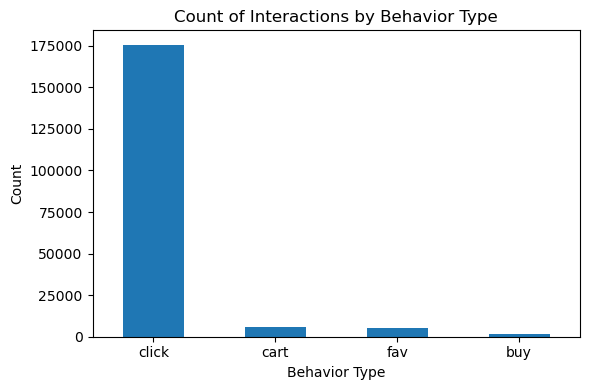

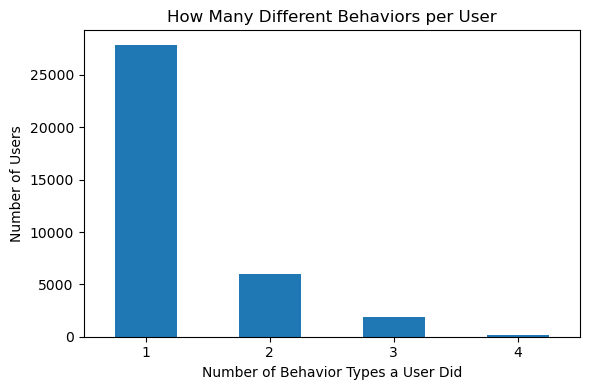

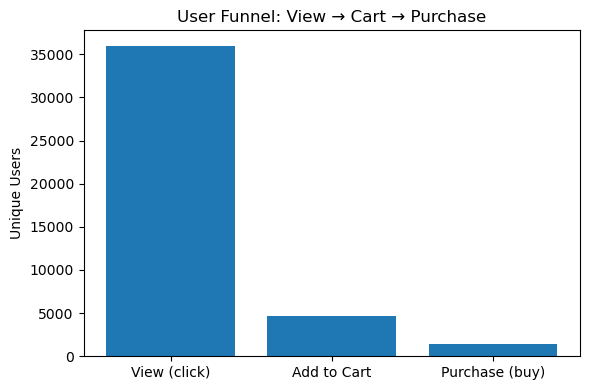

Funnel (unique users): {'View (click)': 35970, 'Add to Cart': 4670, 'Purchase (buy)': 1466}
Click → Cart: 12.98%
Cart → Purchase: 31.39%
Overall View → Purchase: 4.08%


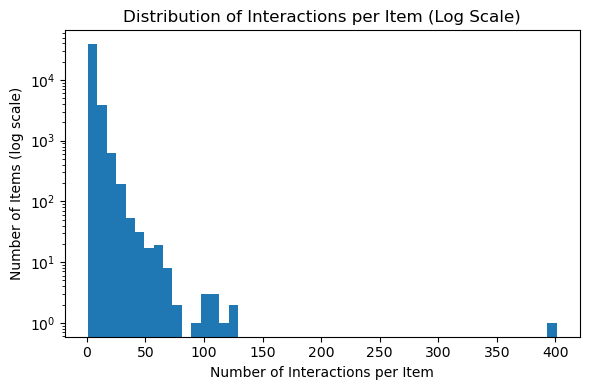

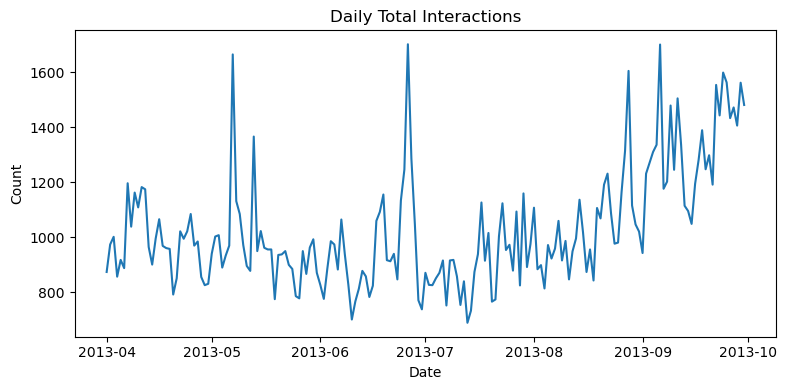

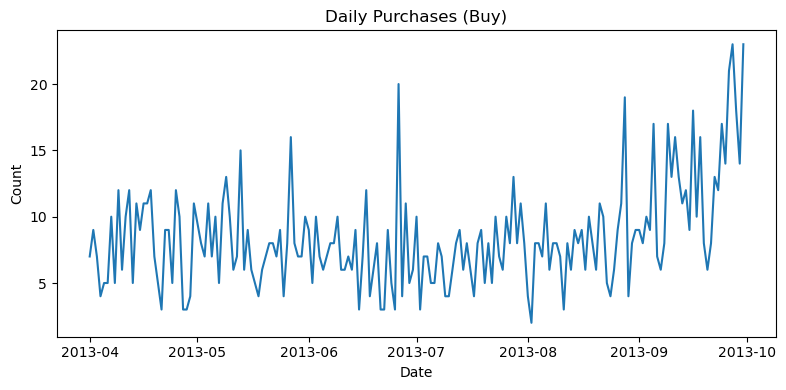

In [520]:
# Define the expected behaviours
all_behaviors = ["click", "fav", "cart", "buy"]

# Count behaviours in df
behavior_counts = df["behavior_type"].value_counts()

# Reindex to include all behaviors (fill missing with 0)
behavior_counts = behavior_counts.reindex(all_behaviors, fill_value=0)

# EDA Visualizations for Imbalance & Segmentation Rationale
# ---------------------------------------------------------
# 1) Counts by behavior type
# 2) Number of behavior types per user
# 3) User funnel (unique users: view -> cart -> purchase)
# 4) Item popularity long-tail (log-scale)
# 5) Daily activity & purchases over time (if time_col parses)

# =========================
# 1) Behavior distribution
# =========================
plt.figure(figsize=(6,4))
df["behavior_type"].value_counts().plot(kind="bar")
plt.title("Count of Interactions by Behavior Type")
plt.ylabel("Count")
plt.xlabel("Behavior Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# =====================================
# 2) How many different behaviors/user
# =====================================
user_behaviors = df.groupby("user_id")["behavior_type"].nunique()
plt.figure(figsize=(6,4))
user_behaviors.value_counts().sort_index().plot(kind="bar")
plt.title("How Many Different Behaviors per User")
plt.xlabel("Number of Behavior Types a User Did")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# =============================
# 3) Funnel: view -> cart -> buy
# =============================
funnel = {
    "View (click)": df.loc[df["behavior_type"]=="click", "user_id"].nunique(),
    "Add to Cart": df.loc[df["behavior_type"]=="cart", "user_id"].nunique(),
    "Purchase (buy)": df.loc[df["behavior_type"]=="buy", "user_id"].nunique(),
}

plt.figure(figsize=(6,4))
plt.bar(list(funnel.keys()), list(funnel.values()))
plt.title("User Funnel: View → Cart → Purchase")
plt.ylabel("Unique Users")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print quick conversion rates for the text
view_users = funnel["View (click)"] or 1
cart_users = funnel["Add to Cart"] or 1
purchase_users = funnel["Purchase (buy)"]

view_to_cart = cart_users / view_users
cart_to_purchase = (purchase_users / cart_users) if cart_users else 0.0
overall_view_to_purchase = purchase_users / view_users

print("Funnel (unique users):", funnel)
print(f"Click → Cart: {view_to_cart:.2%}")
print(f"Cart → Purchase: {cart_to_purchase:.2%}")
print(f"Overall View → Purchase: {overall_view_to_purchase:.2%}")

# ===================================
# 4) Item popularity (long-tail shape)
# ===================================
item_col = "item_id_clean" if "item_id_clean" in df.columns else "item_id_log"
item_counts = df[item_col].value_counts()

plt.figure(figsize=(6,4))
plt.hist(item_counts, bins=50)
plt.yscale("log")
plt.title("Distribution of Interactions per Item (Log Scale)")
plt.xlabel("Number of Interactions per Item")
plt.ylabel("Number of Items (log scale)")
plt.tight_layout()
plt.show()

# ========================================
# 5) time series (daily behaviour)
# ========================================
if df["time"].notna().any():
    daily = df.dropna(subset=["time"]).copy()
    daily["date"] = daily["time"].dt.date
    daily_counts = daily.groupby("date")["user_id"].count()
    daily_purchases = daily.loc[daily["behavior_type"]=="buy"].groupby("date")["user_id"].count()

    plt.figure(figsize=(8,4))
    daily_counts.plot()
    plt.title("Daily Total Interactions")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    daily_purchases.plot()
    plt.title("Daily Purchases (Buy)")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("time_col could not be parsed; skipping time series plots.")


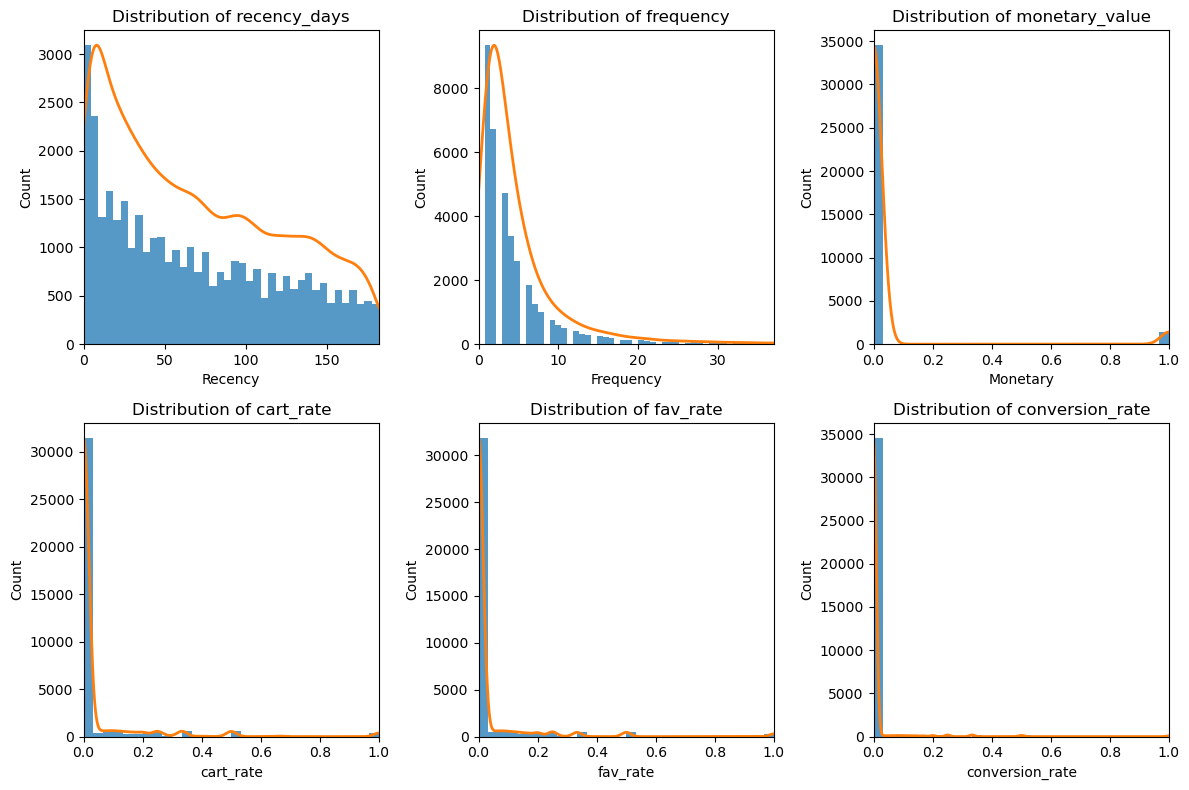

In [432]:
# ================================
# Feature-engineering visuals
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

U_full = user_df.copy(deep=True)                     # full population

def hist_kde(ax, x, title, xlabel, bins, rng):
    x = pd.Series(x, dtype="float64").dropna().values
    counts, edges, _ = ax.hist(x, bins=bins, range=rng, alpha=0.75)
    hmax = counts.max() if counts.size else 1.0
    if x.size > 1:
        width = (rng[1] - rng[0]) or 1.0
        std = np.std(x) if np.std(x) > 0 else width/10
        n = x.size
        bw = max(1.06*std*(n**(-1/5)), width/200)
        kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(x.reshape(-1,1))
        grid = np.linspace(rng[0], rng[1], 400).reshape(-1,1)
        dens = np.exp(kde.score_samples(grid))
        if dens.max() > 0:
            ax.plot(grid.ravel(), (dens/dens.max())*hmax, linewidth=2)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel("Count"); ax.set_xlim(*rng)

# ---------- A) FULL POPULATION ----------
fig, axes = plt.subplots(2,3, figsize=(12,8)); axs = axes.ravel()
hist_kde(axs[0], U_full["recency_days"],       "Distribution of recency_days", "Recency",     40, (0, int(U_full["recency_days"].max())))
hist_kde(axs[1], U_full["frequency"],          "Distribution of frequency",    "Frequency",   50, (0, int(U_full["frequency"].quantile(0.99))))
hist_kde(axs[2], U_full["monetary_value"],     "Distribution of monetary_value","Monetary",   30, (0, int(U_full["monetary_value"].quantile(0.99))))
hist_kde(axs[3], U_full["cart_rate"].clip(0,1),"Distribution of cart_rate",    "cart_rate",   30, (0.0,1.0))
hist_kde(axs[4], U_full["fav_rate"].clip(0,1), "Distribution of fav_rate",     "fav_rate",    30, (0.0,1.0))
hist_kde(axs[5], U_full["conversion_rate"].clip(0,1),
                                            "Distribution of conversion_rate", "conversion_rate", 30, (0.0,1.0))
plt.tight_layout(); plt.show()



Items total: 43,466
Items with pv ≥ 50: 45
Buy-rate (pv ≥ threshold) — mean:0.004  median:0.000  p95:0.019


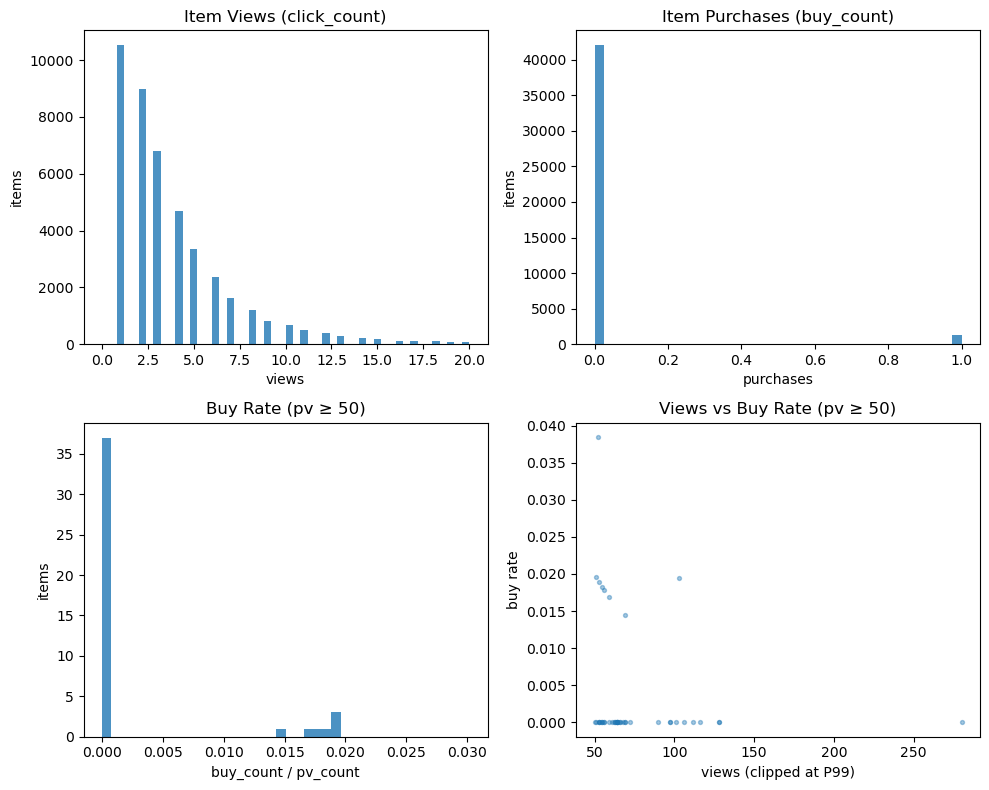

In [258]:
# ================================
# ITEM-LEVEL (RAW scale)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Build item_df (RAW) ---
if "item_df" not in globals():
    assert "time" in df.columns and "behavior_type" in df.columns, "Run the cleaning cell first."
    # pick an item id column present in your file
    for c in ["item_id_clean","item_id_log","item_id"]:
        if c in df.columns:
            ITEM = c; break
    else:
        raise ValueError("No item id column found.")
    g_item = df.groupby(ITEM, sort=False)
    counts = (df.groupby([ITEM,"behavior_type"]).size()
                .unstack("behavior_type")
                .rename(columns={"pv":"pv_count","cart":"cart_count","fav":"fav_count","buy":"buy_count"}))
    for col in ["pv_count","cart_count","fav_count","buy_count"]:
        if col not in counts.columns: counts[col] = 0
    max_time = df["time"].max()
    item_df = pd.concat([
        counts,
        g_item["user_id"].nunique().rename("unique_users"),
        (max_time - g_item["time"].max()).dt.days.rename("recency_days")
    ], axis=1).fillna(0).astype({"pv_count":int,"cart_count":int,"fav_count":int,"buy_count":int,
                                 "unique_users":int,"recency_days":int})

# --- Simple rates (RAW) ---
item_df["buy_rate"] = np.where(item_df["pv_count"]>0, item_df["buy_count"]/item_df["pv_count"], 0.0).clip(0,1)

# --- Minimum views to avoid tiny-denominator noise ---
PV_MIN = 50
items_ok = item_df[item_df["pv_count"] >= PV_MIN].copy()

# --- Quick textual summary (prints to console) ---
print(f"Items total: {len(item_df):,}")
print(f"Items with pv ≥ {PV_MIN}: {len(items_ok):,}")
print("Buy-rate (pv ≥ threshold) — mean:{:.3f}  median:{:.3f}  p95:{:.3f}".format(
    items_ok["buy_rate"].mean(), items_ok["buy_rate"].median(), items_ok["buy_rate"].quantile(0.95)))

# ================================
# Plots (Matplotlib only)
# ================================
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes.ravel()

# 1) Views per item (cap x at P99 so one bar doesn't dominate)
pv_p99 = int(item_df["pv_count"].quantile(0.99))
ax[0].hist(item_df["pv_count"], bins=50, range=(0, pv_p99), alpha=0.8)
ax[0].set_title("Item Views (click_count)"); ax[0].set_xlabel("views"); ax[0].set_ylabel("items")

# 2) Purchases per item (cap x at P99)
buy_p99 = int(item_df["buy_count"].quantile(0.99))
ax[1].hist(item_df["buy_count"], bins=40, range=(0, buy_p99), alpha=0.8)
ax[1].set_title("Item Purchases (buy_count)"); ax[1].set_xlabel("purchases"); ax[1].set_ylabel("items")

# 3) Buy rate histogram with min-views guard
br_p99 = float(items_ok["buy_rate"].quantile(0.99))
ax[2].hist(items_ok["buy_rate"], bins=40, range=(0, br_p99), alpha=0.8)
ax[2].set_title(f"Buy Rate (pv ≥ {PV_MIN})"); ax[2].set_xlabel("buy_count / pv_count"); ax[2].set_ylabel("items")

# 4) Simple scatter: views vs buy rate (sample to keep it readable)
S = items_ok.sample(n=min(8000, len(items_ok)), random_state=7)
xmax = int(items_ok["pv_count"].quantile(0.99))
ax[3].scatter(S["pv_count"].clip(0, xmax), S["buy_rate"], s=8, alpha=0.4)
ax[3].set_title(f"Views vs Buy Rate (pv ≥ {PV_MIN})")
ax[3].set_xlabel("views (clipped at P99)"); ax[3].set_ylabel("buy rate")

plt.tight_layout()
Path("results_figures").mkdir(parents=True, exist_ok=True)
plt.savefig("results_figures/fig_item_eda_simple.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# =========================================
# SEGMENTATION: model matrix → k-selection → final fit → profiles
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


Model matrix shape: (35993, 8)


,k,SSE,Silhouette
0,2,47831.534930,0.367444
1,3,36177.119505,0.372599
2,4,30034.498559,0.397594
3,5,25823.365111,0.328171
4,6,22176.113965,0.352267
5,7,18986.015519,0.349837
6,8,16148.228760,0.345512


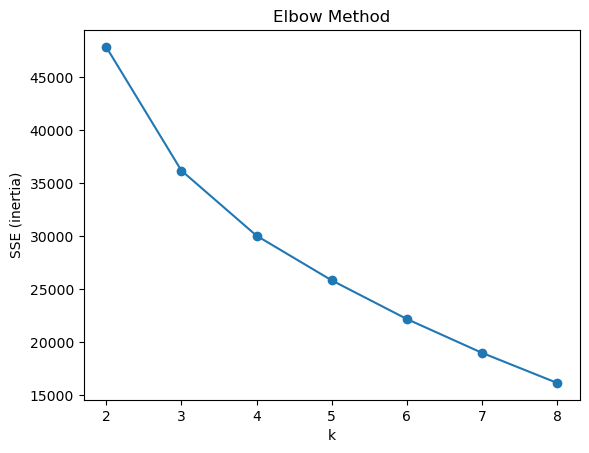

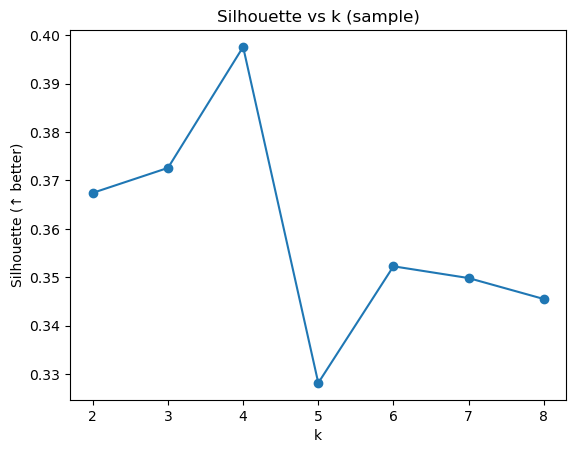

Chosen k (by Silhouette peak): 4

Final model quality — Silhouette: 0.290 (↑) | CH: 12520.1 (↑) | DB: 1.181 (↓)

Cluster sizes & shares:
          users  share_%
cluster                
1         8833    24.54
2        11048    30.69
3         1461     4.06
4        14651    40.71

Cluster mean profile (RAW scale):
          recency_days  frequency  monetary_value  pv_count  cart_count  \
cluster                                                                  
1              46.501     12.729           0.000    12.042       0.284   
2             126.835      1.816           0.000     1.724       0.043   
3              61.821     11.507           1.049     9.145       1.099   
4              36.211      2.652           0.000     2.507       0.083   

         fav_count  buy_count  cart_rate  fav_rate  conversion_rate  \
cluster                                                               
1            0.403      0.000      0.029     0.040             0.00   
2            0.049      

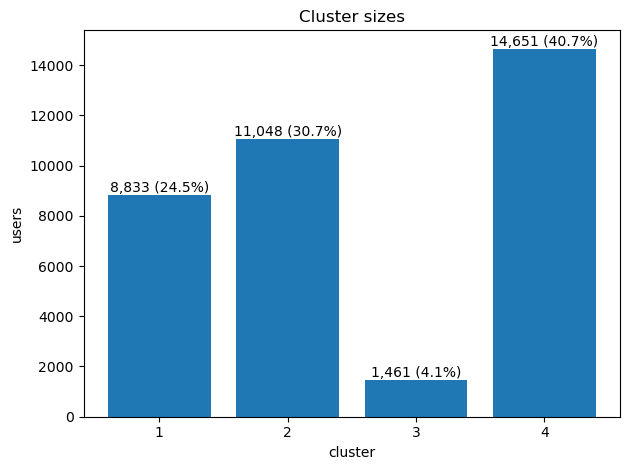

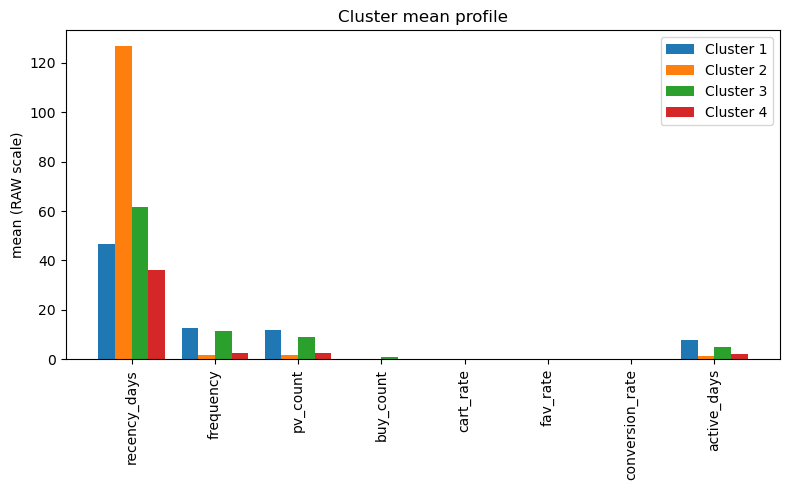

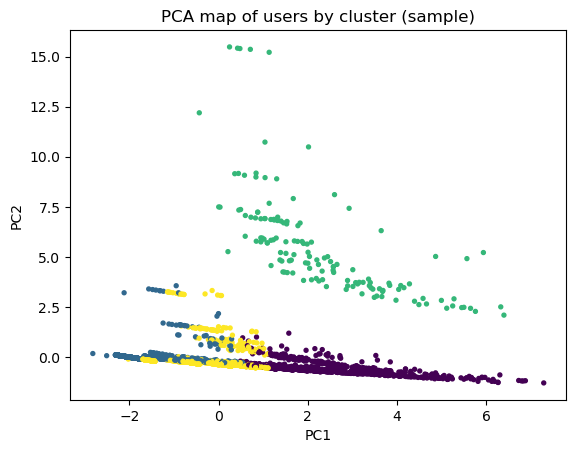

Saved: /Users/arisara/results_segmentation


In [399]:

# ---------- 0) Build MODEL matrix from RAW user_df (do NOT mutate user_df) ----------
feat_cols = [
    "recency_days", "frequency", "monetary_value", "pv_count",
    "cart_rate", "fav_rate", "conversion_rate", "active_days"
]

X_model = user_df[feat_cols].copy()

# log1p for heavy-tailed counts only
for c in ["frequency", "monetary_value", "pv_count", "active_days"]:
    X_model[c] = np.log1p(X_model[c])

# z-score standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)

print("Model matrix shape:", X_scaled.shape)

# ---------- 1) k-selection diagnostics (SSE + Silhouette) ----------
K = range(2, 9)
rows = []
# subsample for speed if very large
sample_n = min(8000, X_scaled.shape[0])
idx = np.random.RandomState(42).choice(X_scaled.shape[0], size=sample_n, replace=False)
Xs = X_scaled[idx]

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lab = km.fit_predict(Xs)
    rows.append({
        "k": k,
        "SSE": km.inertia_,
        "Silhouette": silhouette_score(Xs, lab, sample_size=min(2000, len(Xs)))
    })

diag_df = pd.DataFrame(rows)
display(diag_df)

plt.figure()
plt.plot(diag_df["k"], diag_df["SSE"], marker="o")
plt.xlabel("k"); plt.ylabel("SSE (inertia)"); plt.title("Elbow Method")
plt.show()

plt.figure()
plt.plot(diag_df["k"], diag_df["Silhouette"], marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette (↑ better)"); plt.title("Silhouette vs k (sample)")
plt.show()

best_k = int(diag_df.loc[diag_df["Silhouette"].idxmax(), "k"])
print("Chosen k (by Silhouette peak):", best_k)


# ---------- 2) Final fit on FULL data ----------
USE_MINIBATCH = (X_scaled.shape[0] > 30000)  # toggle for speed
if USE_MINIBATCH:
    km_final = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=2048, n_init=10, max_iter=200)
else:
    km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10, max_iter=300)

labels = km_final.fit_predict(X_scaled)
user_segments = labels  # attach labels to RAW table for interpretable profiling

# quick internal metrics (on FULL model matrix)
sil = silhouette_score(X_scaled, labels, sample_size=min(5000, len(X_scaled)))
ch  = calinski_harabasz_score(X_scaled, labels)
db  = davies_bouldin_score(X_scaled, labels)

# After fitting KMeans
labels = km_final.fit_predict(X_scaled)

# Shift labels from 0..2 → 1..3
user_df["cluster"] = labels + 1

if "user_id" in user_df.columns:
    user_segments = dict(zip(user_df["user_id"], user_df["cluster"]))
else:
    # fallback: use the dataframe index as the user identifier
    user_segments = user_df["cluster"].to_dict()
    

print(f"\nFinal model quality — Silhouette: {sil:.3f} (↑) | CH: {ch:.1f} (↑) | DB: {db:.3f} (↓)")

# ---------- 3) Profiles on RAW scale ----------
profile_cols = [
    "recency_days","frequency","monetary_value","pv_count",
    "cart_count","fav_count","buy_count",
    "cart_rate","fav_rate","conversion_rate","active_days"
]

sizes = user_df["cluster"].value_counts().sort_index()
shares = (100 * user_df["cluster"].value_counts(normalize=True).sort_index()).round(2)

cluster_means = user_df.groupby("cluster")[profile_cols].mean().round(3)

overall_mean = user_df[profile_cols].mean()
overall_std  = user_df[profile_cols].std(ddof=0).replace(0, 1.0)
z_profile = ((user_df.groupby("cluster")[profile_cols].mean() - overall_mean) / overall_std).round(2)

print("\nCluster sizes & shares:\n", pd.DataFrame({"users": sizes, "share_%": shares}))
print("\nCluster mean profile (RAW scale):\n", cluster_means)
print("\nCluster distinctiveness (z-scores vs overall):\n", z_profile)


# ---------- 4) Simple visuals ----------

# sizes & shares
sizes = user_df["cluster"].value_counts().sort_index()
shares = (100 * user_df["cluster"].value_counts(normalize=True).sort_index())

fig, ax = plt.subplots()
bars = ax.bar(sizes.index.astype(str), sizes.values)
ax.set_xlabel("cluster"); ax.set_ylabel("users"); ax.set_title("Cluster sizes")

# annotate
for bar, pct in zip(bars, shares.values):
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h,
            f"{int(h):,} ({pct:.1f}%)",
            ha="center", va="bottom", fontsize=10)
plt.tight_layout(); plt.show()



# mean profiles (grouped bar)
features = ["recency_days","frequency","pv_count","buy_count","cart_rate","fav_rate","conversion_rate","active_days"]
clusters = list(cluster_means.index.astype(int))
x = np.arange(len(features))
width = 0.8 / len(clusters)

plt.figure(figsize=(max(8, len(features)*0.7), 5))
for i, c in enumerate(clusters):
    plt.bar(x + i*width - (len(clusters)-1)*width/2,
            cluster_means.loc[c, features].values,
            width=width, label=f"Cluster {c}")
plt.xticks(x, features, rotation=90)
plt.ylabel("mean (RAW scale)"); plt.title("Cluster mean profile")
plt.legend(); plt.tight_layout(); plt.show()



In [282]:
#PART4

# Define weight mapping for behaviors

weight_map = {"click": 0.2, "fav": 0.5, "cart": 0.7, "buy": 1.0}
df["weight"] = df["behavior_type"].map(weight_map)

# Temporal split: 80% train, 20% test
df["time_col"] = pd.to_datetime(df["time_col"], errors="coerce")
min_time, max_time = df["time_col"].min(), df["time_col"].max()
cutoff = min_time + 0.8 * (max_time - min_time)

train_df = df[df["time_col"] <= cutoff].copy()
test_df  = df[df["time_col"] > cutoff].copy()

# Aggregate into user-item weighted matrices
train_matrix = train_df.groupby(["user_id","item_id_clean"])["weight"].sum().reset_index()
test_matrix  = test_df.groupby(["user_id","item_id_clean"])["weight"].sum().reset_index()

print("Train size:", train_matrix.shape)
print("Test size:", test_matrix.shape)


Train size: (89062, 3)
Test size: (31556, 3)


In [284]:
import pandas as pd


# Keep only meaningful interactions (>0)
df = df[df["weight"] > 0].copy()

# --- Eligibility: users with total train weight >= 0.1 ---
user_total_weight = train_df.groupby("user_id")["weight"].sum()
eligible_users = set(user_total_weight[user_total_weight >= 0.1].index)
print("Eligible users (>=0.1 train weight):", len(eligible_users))

# --- Filter to eligible users (optional but recommended for evaluation) ---
train_df_elig = train_df[train_df["user_id"].isin(eligible_users)].copy()
test_df_elig  = test_df[test_df["user_id"].isin(eligible_users)].copy()

# --- Build user–item matrices (weighted sums) ---
train_matrix = (
    train_df_elig.groupby(["user_id", "item_id_clean"])["weight"]
    .sum()
    .reset_index()
)
test_matrix = (
    test_df_elig.groupby(["user_id", "item_id_clean"])["weight"]
    .sum()
    .reset_index()
)

print("train_df_elig:", train_df_elig.shape, "| test_df_elig:", test_df_elig.shape)
print("train_matrix:", train_matrix.shape,   "| test_matrix:", test_matrix.shape)



Eligible users (>=0.1 train weight): 30258
train_df_elig: (139937, 11) | test_df_elig: (24162, 11)
train_matrix: (89062, 3) | test_matrix: (16258, 3)


In [286]:
# --- Eligible users info table ---
# Compute per-user stats in TRAIN
user_total_weight = train_df.groupby("user_id")["weight"].sum()
user_interactions = train_df.groupby("user_id")["item_id_clean"].count()
user_days = train_df.groupby("user_id")["time_col"].nunique()

# Users who pass criterion (>=0.1 total weight in train)
eligible_users = user_total_weight[user_total_weight >= 0.1].index

# Build info DataFrame
eligible_info = pd.DataFrame({
    "user_id": eligible_users,
    "train_total_weight": user_total_weight.loc[eligible_users].values,
    "train_interactions": user_interactions.loc[eligible_users].values,
    "train_active_days": user_days.loc[eligible_users].values
})

# Reset index for clean display
eligible_info = eligible_info.reset_index(drop=True)

# Show a sample of eligible users
print("Total eligible users:", len(eligible_info))
print(eligible_info.head(10))   # view first 10 rows

Total eligible users: 30258
   user_id  train_total_weight  train_interactions  train_active_days
0      149                 0.6                   3                  3
1      374                 0.2                   1                  1
2      578                 0.2                   1                  1
3      704                 1.2                   6                  6
4     1330                 2.5                   6                  6
5     1705                 0.2                   1                  1
6     1850                 0.4                   2                  2
7     1853                 0.2                   1                  1
8     1956                 1.3                   5                  5
9     2392                 0.4                   2                  2


In [288]:
eligible_info

,user_id,train_total_weight,train_interactions,train_active_days
0,149,0.6,3,3
1,374,0.2,1,1
2,578,0.2,1,1
3,704,1.2,6,6
4,1330,2.5,6,6
...,...,...,...,...
30253,8132672,0.2,1,1
30254,8132680,0.2,1,1
30255,8132851,1.4,7,7
30256,8132987,3.4,17,17


In [292]:
# === Canonical IDs (ONE source of truth) ===

assert "user_id" in df.columns, "user_id missing in df"
assert "item_id_clean" in df.columns, "item_id_clean missing in df"

# Helpful product lookup (for nice tables)
product_df = (
    df.loc[:, ["item_id_clean", "title"]]
      .drop_duplicates()
      .rename(columns={"title": "product_name"})
)


In [298]:
# --- Popularity baseline recommender ---
def recommend_popularity(user_id=None, K=10):
    """
    Popularity baseline recommender.
    Returns the same Top-K most popular items for every user.
    """
    # Rank items by total weighted interactions
    popularity_scores = (
        train_matrix.groupby("item_id_clean")["weight"]
        .sum()
        .reset_index()
        .sort_values(by="weight", ascending=False)
        .rename(columns={"weight": "popularity_score"})
    )

    # Count interactions
    popularity_counts = (
        train_matrix.groupby("item_id_clean")["weight"]
        .count()
        .reset_index()
        .rename(columns={"weight": "interaction_count"})
    )

    # Merge with product info
    item_info = df[["item_id_clean", "title"]].drop_duplicates()
    popular_items = (
        popularity_scores
        .merge(item_info, on="item_id_clean", how="left")
        .merge(popularity_counts, on="item_id_clean", how="left")
        .rename(columns={"title": "product_name"
        })
    )

    # Select Top-K
    topK_popular = popular_items.head(K)[
        ["item_id_clean", "product_name", "popularity_score", "interaction_count"]
    ]

    return topK_popular



In [300]:
# Get Top-10 most popular items
top10_popular = recommend_popularity(K=10)
display(top10_popular)

# For a specific user (same output since baseline is non-personalised)
user_popular = recommend_popularity(user_id=149, K=10)
display(user_popular)


,item_id_clean,product_name,popularity_score,interaction_count
0,3181922,佰草集 / Herborist 新 玉 润 保湿 菁华 露 50 g / ml 所有...,60.6,35
1,5983557,2013 日系 厚底鱼嘴鞋 撞色 条纹 坡跟 超高跟 潮流 女 鞋子 漆皮 夏季凉鞋,25.6,1
2,2746354,海昌 恋爱魔镜 混血 美 曈 隐形眼镜 半年抛 1 片 装 包邮 1 副 拍 2 片,21.2,1
3,4241446,墙贴 开关贴纸 特价 韩国 创意 时尚 家居灯 装饰 卡通 可爱 小红 兔子 043,20.3,7
4,4739560,倍速 学习 法 八 年级 8 年级 物理 上 苏科 版 初中 教辅 13 年 6月,20.2,5
5,6708483,正品 人本 新款 高帮 女士 PU 亮皮面 韩版 潮 女 厚底松糕鞋 可 擦洗 防水短靴,20.2,5
6,641196,正版 雅思 考试 金牌 教程 5 分 - 6.5 分 航道 英语 丛书 胡敏 第6 代 ...,19.4,3
7,4176444,ALT 阿恩 蓝 拓 短袖T恤 男士 合体 休闲 纯棉 圆领 2013 夏季新款...,17.8,43
8,5830594,辉瑞 大宠爱 宠物 滴剂 赛拉 菌 素 大型犬 体 内外 驱虫 整 盒装 新...,15.3,7
9,4182405,2013 秋装新品 职业装 女装衬衫 修身 时尚 韩版 显 瘦 女士 蕾丝雪纺衫 衬衣,15.3,11


,item_id_clean,product_name,popularity_score,interaction_count
0,3181922,佰草集 / Herborist 新 玉 润 保湿 菁华 露 50 g / ml 所有...,60.6,35
1,5983557,2013 日系 厚底鱼嘴鞋 撞色 条纹 坡跟 超高跟 潮流 女 鞋子 漆皮 夏季凉鞋,25.6,1
2,2746354,海昌 恋爱魔镜 混血 美 曈 隐形眼镜 半年抛 1 片 装 包邮 1 副 拍 2 片,21.2,1
3,4241446,墙贴 开关贴纸 特价 韩国 创意 时尚 家居灯 装饰 卡通 可爱 小红 兔子 043,20.3,7
4,4739560,倍速 学习 法 八 年级 8 年级 物理 上 苏科 版 初中 教辅 13 年 6月,20.2,5
5,6708483,正品 人本 新款 高帮 女士 PU 亮皮面 韩版 潮 女 厚底松糕鞋 可 擦洗 防水短靴,20.2,5
6,641196,正版 雅思 考试 金牌 教程 5 分 - 6.5 分 航道 英语 丛书 胡敏 第6 代 ...,19.4,3
7,4176444,ALT 阿恩 蓝 拓 短袖T恤 男士 合体 休闲 纯棉 圆领 2013 夏季新款...,17.8,43
8,5830594,辉瑞 大宠爱 宠物 滴剂 赛拉 菌 素 大型犬 体 内外 驱虫 整 盒装 新...,15.3,7
9,4182405,2013 秋装新品 职业装 女装衬衫 修身 时尚 韩版 显 瘦 女士 蕾丝雪纺衫 衬衣,15.3,11


In [302]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Pivot to user–item matrix
user_item_matrix = train_matrix.pivot_table(
    index="user_id", columns="item_id_clean", values="weight", fill_value=0
)

# Compute item–item cosine similarity
item_sim = cosine_similarity(user_item_matrix.T)
item_sim_df = pd.DataFrame(
    item_sim, index=user_item_matrix.columns, columns=user_item_matrix.columns
)



In [304]:
# Function: recommend Top-K items for a user
def recommend_itemcf(user_id, K=10):
    # user_item_matrix is pivot (index=user_id)
    if user_id not in user_item_matrix.index:
        return []  # or raise ValueError(f"Unknown user_id: {user_id}")
    user_vector = user_item_matrix.loc[user_id]
    interacted_items = user_vector[user_vector > 0].index
    scores = {}
    for item in interacted_items:
        similar_items = item_sim_df[item].drop(interacted_items, errors="ignore")
        for sim_item, score in similar_items.items():
            scores[sim_item] = scores.get(sim_item, 0.0) + score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [i for i,_ in ranked[:K]]




In [310]:
def recommend_itemcf(user_id, K=10, weight_by_user_pref=True):
    if user_id not in user_item_matrix.index:
        return pd.DataFrame()  # no history
    
    user_vector = user_item_matrix.loc[user_id]
    interacted_items = user_vector[user_vector > 0].index
    
    scores = {}
    for src_item in interacted_items:
        neigh = item_sim_df[src_item].drop(interacted_items, errors="ignore")
        w = user_vector[src_item] if weight_by_user_pref else 1.0
        for tgt_item, sim in neigh.items():
            if sim <= 0: 
                continue
            scores[tgt_item] = scores.get(tgt_item, 0.0) + sim * w
    
    # Rank Top-K
    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:K]
    rec_df = pd.DataFrame(ranked, columns=["item_id_clean", "cf_score"])
    
    # Attach product info
    item_info = df[["item_id_clean", "title"]].drop_duplicates()
    rec_df = rec_df.merge(item_info, on="item_id_clean", how="left") \
                   .rename(columns={"title": "Product name"})
    
    # Add user_id + rank
    rec_df.insert(0, "user_id", user_id)
    rec_df.insert(0, "rank", range(1, len(rec_df)+1))

    
    # Reorder columns nicely
    rec_df = rec_df[["rank", "user_id","item_id_clean", "Product name", "cf_score"]]
    
    return rec_df



In [312]:
# Example: Top 10 recs for user 149
user_id = 149
top10_recs = recommend_itemcf(user_id, K=10)
top10_recs

,rank,user_id,item_id_clean,Product name,cf_score
0,1,149,1703475,包邮 洁丽雅 正品 全棉 纯棉方巾 彩色 百搭 小 方巾 柔软 舒适,0.156893
1,2,149,3447827,西安 一日游 兵马俑 一日游 东线 一日游 兵马俑 华清池 票 西安兵马俑,0.156893
2,3,149,3411961,包邮 男装 全棉 韩版 修身短袖T恤 男士 短款 夏装 t 男 恤 植绒 印花 潮 男款,0.115470
3,4,149,6373080,天才 儿童 阶梯 思维 训练 200 题 & mdash ; & mdash ; 5 ～ 6...,0.115470
4,5,149,7297392,天使 的 口袋 童装 爱相随 中大 童 外套 女童棉衣 童装棉袄 2011 冬季 新品,0.115470
5,6,149,7743733,新1系 专柜正品 莫代尔 面料 女 魅力 红色 小吊带 背心 新一系 33789,0.115196
6,7,149,2541034,铅笔俱乐部 童装 秋装 新款 女童打底衫 保暖 圆领长袖毛衣 儿童针织衫,0.111027
7,8,149,544006,汽车烟灰缸 车载烟灰缸 车用烟灰缸 汽车用品 车内 饰,0.110940
8,9,149,3467789,ONLY 【 专柜正品 】 露肩 两件套 条纹 热销 薄款针织衫,0.110940
9,10,149,508273,上海 鲜花速递 上海 花店 徐汇 鲜花店 闵行 优尚 浦东 普陀 12 支 香水百合 07,0.109545


In [314]:
# 0) Product names
product_df = df[["item_id_clean", "title"]].drop_duplicates() \
               .rename(columns={"title": "product_name"})

# 1) Build cluster_df from results in user_df
def build_cluster_df(user_df: pd.DataFrame) -> pd.DataFrame:
    assert "cluster" in user_df.columns, "user_df must contain 'cluster'."
    if "user_id" in user_df.columns:
        cdf = user_df[["user_id", "cluster"]].copy()
    else:
        tmp = user_df.reset_index()
        id_col = [c for c in tmp.columns if c != "cluster"][0]
        cdf = tmp[[id_col, "cluster"]].rename(columns={id_col: "user_id"})
    cdf["user_id"] = pd.to_numeric(cdf["user_id"], errors="coerce").astype("Int64")
    cdf["cluster"] = pd.to_numeric(cdf["cluster"], errors="coerce").astype("Int64")
    return cdf.dropna(subset=["user_id","cluster"]).astype({"user_id":int,"cluster":int})

cluster_df = build_cluster_df(user_df)
user_segments = dict(zip(cluster_df.user_id, cluster_df.cluster))

# 2) Standardize any CF output to required schema
def standardize_cf_rec_df(user_id: int, cf_rec_df: pd.DataFrame) -> pd.DataFrame:
    out = cf_rec_df.copy()
    rename_map = {}
    if "item_id_clean" not in out.columns:
        for cand in ["item_id","Item ID","item","product_id"]:
            if cand in out.columns: rename_map[cand] = "item_id_clean"; break
    if "cf_score" not in out.columns:
        for cand in ["score","pred","rank_score","sim_score"]:
            if cand in out.columns: rename_map[cand] = "cf_score"; break
    if rename_map: out = out.rename(columns=rename_map)
    if "user_id" not in out.columns:
        out.insert(0, "user_id", user_id)
    if "product_name" not in out.columns:
        out = out.merge(product_df, on="item_id_clean", how="left")
    need = ["user_id","product_name","item_id_clean","cf_score"]
    missing = [c for c in need if c not in out.columns]
    if missing:
        raise ValueError(f"CF input missing columns after standardization: {missing}")
    return out[need]

# 3) Build COMPLETE segment×item lift (smoothed), so every pair has a score
def build_segment_item_lift(train_df: pd.DataFrame, cluster_df: pd.DataFrame, tau: float = 1.0):
    twc = (train_df.merge(cluster_df, on="user_id", how="left")
                  .dropna(subset=["cluster"]).copy())
    twc["cluster"] = twc["cluster"].astype(int)
    twc["item_id_clean"] = pd.to_numeric(twc["item_id_clean"], errors="coerce").astype("Int64")
    twc = twc.dropna(subset=["item_id_clean"]).astype({"item_id_clean":int})

    seg_totals  = twc.groupby("cluster")["weight"].sum()                    # (S,)
    item_totals = twc.groupby("item_id_clean")["weight"].sum()              # (I,)
    w_seg_item  = twc.groupby(["cluster","item_id_clean"])["weight"].sum()  # sparse observed

    segments = seg_totals.index.tolist()
    items    = item_totals.index.tolist()
    global_total = float(twc["weight"].sum())
    I = len(items)

    # full grid with zeros, then smooth
    W = w_seg_item.reindex(
            pd.MultiIndex.from_product([segments, items], names=["cluster","item_id_clean"]),
            fill_value=0.0
        ).rename("w_seg_item").reset_index()
    W = (W.merge(seg_totals.rename("w_seg_total"), on="cluster", how="left")
           .merge(item_totals.rename("w_item_total"), on="item_id_clean", how="left"))

    W["p_seg"]    = (W["w_seg_item"]  + tau) / (W["w_seg_total"]  + tau*I)
    W["p_global"] = (W["w_item_total"] + tau) / (global_total     + tau*I)
    W["seg_lift"] = (W["p_seg"] / W["p_global"]) - 1.0   # >0 over-indexes, <0 under-indexes

    # lookup {(segment, item): lift}
    return {(int(r.cluster), int(r.item_id_clean)): float(r.seg_lift) for r in W.itertuples(index=False)}

segment_item_scores = build_segment_item_lift(train_df, cluster_df, tau=1.0)

# 4) Re-rank that includes the user's segment in the output
def rerank_with_segment(user_id: int, cf_rec_df: pd.DataFrame, alpha: float = 0.1) -> pd.DataFrame:
    cf = standardize_cf_rec_df(user_id, cf_rec_df).copy()
    cf["item_id_clean"] = pd.to_numeric(cf["item_id_clean"], errors="coerce").astype("Int64").dropna().astype(int)
    seg = user_segments.get(user_id, None)

    cf["segment"] = seg
    if seg is None:
        cf["seg_bonus"] = 0.0
    else:
        s = int(seg)
        cf["seg_bonus"] = cf["item_id_clean"].map(lambda it: alpha * segment_item_scores.get((s, it), 0.0)).fillna(0.0)

    cf["final_score"] = cf["cf_score"] + cf["seg_bonus"]
    cf = cf.sort_values("final_score", ascending=False).reset_index(drop=True)
    cf.insert(0, "rank", cf.index + 1)
    return cf[["rank","user_id","segment","item_id_clean","product_name","cf_score","seg_bonus","final_score"]]

# -------- Example usage --------
# raw_cf = recommend_itemcf(149, K=10)    
# cfseg_top10 = rerank_with_segment(149, raw_cf, alpha=0.1)
# display(cfseg_top10)


In [ ]:
def debug_segment_bonus(user_id: int, cf_rec_df: pd.DataFrame):
    seg = user_segments.get(user_id)
    cf_items = cf_rec_df["item_id_clean"].astype(int).tolist()
    found = sum(((int(seg), int(it)) in segment_item_scores) if seg is not None else 0 for it in cf_items)
    print("User segment:", seg)
    print(f"Segment–item keys found for CF list: {found}/{len(cf_items)}")

# Run:
# cf_rec_df = recommend_itemcf(149, K=10)  # must include product_name & cf_score
# debug_segment_bonus(149, cf_rec_df)  # expect 10/10 now
# cfseg_top10 = rerank_with_segment(149, cf_rec_df, alpha=0.1)
# cfseg_top10

In [318]:
user_id = 149
cf_rec_df = standardize_cf_rec_df(user_id, recommend_itemcf(user_id, K=10))
debug_segment_bonus(user_id, cf_rec_df)
cfseg_top10 = rerank_with_segment(user_id, cf_rec_df, alpha=0.1)
cfseg_top10

User segment: 2
Segment–item keys found for CF list: 10/10


,rank,user_id,segment,item_id_clean,product_name,cf_score,seg_bonus,final_score
0,1,149,2,1703475,包邮 洁丽雅 正品 全棉 纯棉方巾 彩色 百搭 小 方巾 柔软 舒适,0.156893,0.036790,0.193683
1,2,149,2,3447827,西安 一日游 兵马俑 一日游 东线 一日游 兵马俑 华清池 票 西安兵马俑,0.156893,0.036790,0.193683
2,3,149,2,6373080,天才 儿童 阶梯 思维 训练 200 题 & mdash ; & mdash ; 5 ～ 6...,0.115470,0.036790,0.152260
3,4,149,2,7297392,天使 的 口袋 童装 爱相随 中大 童 外套 女童棉衣 童装棉袄 2011 冬季 新品,0.115470,0.036790,0.152260
4,5,149,2,544006,汽车烟灰缸 车载烟灰缸 车用烟灰缸 汽车用品 车内 饰,0.110940,0.017249,0.128189
5,6,149,2,3467789,ONLY 【 专柜正品 】 露肩 两件套 条纹 热销 薄款针织衫,0.110940,0.017249,0.128189
6,7,149,2,3411961,包邮 男装 全棉 韩版 修身短袖T恤 男士 短款 夏装 t 男 恤 植绒 印花 潮 男款,0.115470,0.002593,0.118063
7,8,149,2,508273,上海 鲜花速递 上海 花店 徐汇 鲜花店 闵行 优尚 浦东 普陀 12 支 香水百合 07,0.109545,-0.008806,0.100738
8,9,149,2,2541034,铅笔俱乐部 童装 秋装 新款 女童打底衫 保暖 圆领长袖毛衣 儿童针织衫,0.111027,-0.013606,0.097421
9,10,149,2,7743733,新1系 专柜正品 莫代尔 面料 女 魅力 红色 小吊带 背心 新一系 33789,0.115196,-0.059964,0.055233


In [320]:
# === FAST BUILDERS: pop_recs, ibcf_recs, hybrid_recs (no per-user function calls) ===
import numpy as np
import pandas as pd
from collections import defaultdict
from heapq import nlargest

# 0) Prep
assert {"user_id","item_id_clean"}.issubset(train_df.columns), "train_df missing cols"
assert {"user_id","item_id_clean"}.issubset(test_df.columns),  "test_df  missing cols"

users_eval = sorted(set(train_df["user_id"]) & set(test_df["user_id"]))
TOPN_BUILD = 200

# seen items per user (TRAIN)
pairs = train_df[["user_id","item_id_clean"]].drop_duplicates()
train_user_items = pairs.groupby("user_id")["item_id_clean"].apply(set).to_dict()

# 1) Popularity once, then per-user filter-out of seen
if "weight" in train_df.columns:
    pop_ser = train_df.groupby("item_id_clean")["weight"].sum().sort_values(ascending=False)
else:
    pop_ser = train_df.groupby("item_id_clean").size().sort_values(ascending=False)

pop_list = pop_ser.index.tolist()  # global popularity order
pop_recs = {}
for u in users_eval:
    seen = train_user_items.get(u, set())
    # take first TOPN_BUILD items not seen
    # (comprehension is faster than calling per-user functions)
    pop_recs[u] = [i for i in pop_list if i not in seen][:TOPN_BUILD]

# 2) Item-to-Item CF using co-occurrence (computed once)
#    cosine-like similarity: sim(a,b) = co(a,b) / sqrt(deg(a)*deg(b))

# user -> items list
user_items = pairs.groupby("user_id")["item_id_clean"].apply(list)

co_counts = defaultdict(int)
item_deg  = defaultdict(int)

for items in user_items:
    s = list(set(items))
    # degree
    for i in s:
        item_deg[i] += 1
    # undirected co-occurrence
    for a_idx in range(len(s)):
        for b_idx in range(a_idx+1, len(s)):
            a, b = s[a_idx], s[b_idx]
            if a == b: 
                continue
            co_counts[(a,b)] += 1
            co_counts[(b,a)] += 1

def _sim(a, b):
    num = co_counts.get((a,b), 0)
    if num == 0: 
        return 0.0
    da = item_deg.get(a,0); db = item_deg.get(b,0)
    denom = (da * db) ** 0.5
    return (num/denom) if denom > 0 else 0.0

# keep only top-K neighbors per item for speed
NEI_CAP = 200
items_all = list(item_deg.keys())
neighbors = {}
for i in items_all:
    # candidates = items that co-occurred with i
    # quickly skip zeros by checking co_counts key existence
    cands = [(j, co_counts.get((i,j),0)) for j in items_all if j != i and co_counts.get((i,j),0) > 0]
    if not cands:
        neighbors[i] = []
        continue
    sims = [(j, _sim(i,j)) for j,_ in cands]
    neighbors[i] = nlargest(NEI_CAP, sims, key=lambda t: t[1])

# user-level scoring from neighbors
def make_itemcf_recs(users, seen_dict, neighbors, pop_backfill, topN=TOPN_BUILD):
    out = {}
    for u in users:
        seen = seen_dict.get(u, set())
        scores = defaultdict(float)
        # sum similarities of neighbors of items the user has seen
        for i in seen:
            for j, s in neighbors.get(i, []):
                if j in seen:
                    continue
                scores[j] += s
        if scores:
            ranked = sorted(scores.items(), key=lambda t: (-t[1], t[0]))
            recs = [j for j,_ in ranked][:topN]
        else:
            # cold start fallback → popularity (filtered)
            recs = [i for i in pop_backfill if i not in seen][:topN]
        out[u] = recs
    return out

ibcf_recs = make_itemcf_recs(users_eval, train_user_items, neighbors, pop_list, topN=TOPN_BUILD)

# 3) FAST Hybrid = α * norm(ItemCF score per-user) + (1-α) * norm(popularity rank)
#    (No per-user rerank_with_segment calls → much faster)
ALPHA = 0.7

# normalize popularity by rank (higher is better, in [0,1])
pop_rank = {iid: r for r, iid in enumerate(pop_list, start=1)}
max_rank = float(len(pop_list))
pop_score = {iid: 1.0 - (pop_rank[iid]-1)/max_rank for iid in pop_list}

def _minmax(d):
    if not d:
        return {}
    vals = list(d.values())
    lo, hi = min(vals), max(vals)
    if hi <= lo:
        return {k: 0.0 for k in d}
    span = hi - lo
    return {k: (v - lo)/span for k, v in d.items()}

# reuse neighbors to compute per-user itemcf scores (once) for hybrid
def itemcf_scores_per_user(users, seen_dict, neighbors):
    u2scores = {}
    for u in users:
        seen = seen_dict.get(u, set())
        scores = defaultdict(float)
        for i in seen:
            for j, s in neighbors.get(i, []):
                if j in seen:
                    continue
                scores[j] += s
        u2scores[u] = scores
    return u2scores

u_itemcf_scores = itemcf_scores_per_user(users_eval, train_user_items, neighbors)

hybrid_recs = {}
for u in users_eval:
    seen = train_user_items.get(u, set())
    icf_norm = _minmax(u_itemcf_scores.get(u, {}))  # per-user normalized CF scores
    # candidate pool: union of CF candidates + a slice of popularity
    cand = set(icf_norm.keys())
    for i in pop_list[:300]:
        if i not in seen:
            cand.add(i)
    combined = {}
    for j in cand:
        s_icf = icf_norm.get(j, 0.0)
        s_pop = pop_score.get(j, 0.0)
        combined[j] = ALPHA*s_icf + (1-ALPHA)*s_pop
    ranked = sorted(combined.items(), key=lambda t: (-t[1], t[0]))
    hybrid_recs[u] = [j for j,_ in ranked if j not in seen][:TOPN_BUILD]

# Quick sanity
for name, recs in [("pop_recs", pop_recs), ("ibcf_recs", ibcf_recs), ("hybrid_recs", hybrid_recs)]:
    n_users = len(recs)
    non_empty = sum(1 for v in recs.values() if v)
    ex_u = users_eval[0] if users_eval else None
    print(f"{name}: users={n_users}, non-empty={non_empty}, ex_user={ex_u}, top5={recs.get(ex_u, [])[:5]}")


pop_recs: users=7696, non-empty=7696, ex_user=1956, top5=[3181922, 5983557, 2746354, 4241446, 6708483]
ibcf_recs: users=7696, non-empty=7696, ex_user=1956, top5=[1749058, 2291088, 3059293, 3180534, 3227704]
hybrid_recs: users=7696, non-empty=7696, ex_user=1956, top5=[1749058, 2291088, 3180534, 7985107, 3537608]


In [405]:
# === COMPARE TABLE: P/R/F1 @ {10,20} + Coverage, Gini, Novelty ===
import numpy as np
import pandas as pd
from collections import Counter

# 1) Ground truth from TEST (only users that are in both train & test)
users_eval = sorted(set(train_df["user_id"]) & set(test_df["user_id"]))
gt_pairs = (test_df.loc[test_df["user_id"].isin(users_eval), ["user_id","item_id_clean"]]
                   .drop_duplicates())
truth_map = gt_pairs.groupby("user_id")["item_id_clean"].apply(set).to_dict()

# 2) Popularity table for novelty ranking (from TRAIN)
if "weight" in train_df.columns:
    pop_df = (train_df.groupby("item_id_clean")["weight"]
                     .sum().reset_index(name="pop")
                     .sort_values(["pop","item_id_clean"], ascending=[False, True])
                     .reset_index(drop=True))
else:
    pop_df = (train_df.groupby("item_id_clean")
                     .size().reset_index(name="pop")
                     .sort_values(["pop","item_id_clean"], ascending=[False, True])
                     .reset_index(drop=True))

# 3) Evaluation helpers
def _topk(recs_dict, k):
    return {u: recs[:k] for u, recs in recs_dict.items()}

def eval_accuracy(model_recs, truth_map, Ks=(10,20)):
    res = {}
    users = list(truth_map.keys())
    for K in Ks:
        P, R, F1 = [], [], []
        recsK = _topk(model_recs, K)
        for u in users:
            rec = recsK.get(u, [])
            gt  = truth_map[u]
            hits = len(set(rec) & gt)
            p = hits / K if K > 0 else 0.0
            r = hits / len(gt) if len(gt) > 0 else 0.0
            f = 2*p*r/(p+r) if (p+r) > 0 else 0.0
            P.append(p); R.append(r); F1.append(f)
        res[f"P@{K}"]  = float(np.mean(P))
        res[f"R@{K}"]  = float(np.mean(R))
        res[f"F1@{K}"] = float(np.mean(F1))
    return res

def eval_diversity_novelty(model_recs, pop_df, all_items, K=20):
    rec_items = []
    for recs in model_recs.values():
        rec_items.extend(recs[:K])

    # Coverage
    coverage = len(set(rec_items)) / max(1, len(all_items))

    # Gini (exposure inequality, 0=fair, 1=unequal)
    counts = Counter(rec_items)
    freqs = np.array(list(counts.values()), dtype=float)
    if freqs.size == 0:
        gini = np.nan
    else:
        freqs.sort()
        n = float(len(freqs))
        cum = np.cumsum(freqs)
        gini = (n + 1 - 2*np.sum(cum)/cum[-1]) / n

    # Novelty: average popularity rank (higher = more novel)
    pop_rank = {iid: r for r, iid in enumerate(pop_df["item_id_clean"].tolist(), start=1)}
    nov = [pop_rank.get(i, len(all_items)) for i in rec_items]
    novelty = float(np.mean(nov)) if nov else np.nan
    return {"Coverage": coverage, "Gini": gini, "Novelty": novelty}

def compare_models(models_dict, truth_map, pop_df, all_items, Ks=(10,20)):
    rows = []
    for name, recs in models_dict.items():
        acc  = eval_accuracy(recs, truth_map, Ks=Ks)
        divn = eval_diversity_novelty(recs, pop_df, all_items, K=max(Ks))
        row = {"Model": name, **acc, **divn}
        rows.append(row)
    return pd.DataFrame(rows).set_index("Model")

# 4) Catalog & sanity (optional print)
catalog_all = set(pd.concat(
    [train_df["item_id_clean"], test_df["item_id_clean"]],
    ignore_index=True
).unique())

for name, recs in [("Popularity", pop_recs), ("ItemCF", ibcf_recs), ("Hybrid", hybrid_recs)]:
    rec_items = {i for lst in recs.values() for i in lst}
    in_catalog = len(rec_items & catalog_all) / max(1, len(rec_items))
    users_with_hit = np.mean([len(set(recs.get(u, [])[:20]) & truth_map[u]) > 0 for u in truth_map])
    print(f"[Sanity] {name}: %rec_in_catalog={in_catalog:.3f} | %users_with_hit@20={users_with_hit:.3f}")

# 5) Final comparison table
models = {"Popularity": pop_recs, "ItemCF": ibcf_recs, "Hybrid": hybrid_recs}
results_df = compare_models(models, truth_map, pop_df, catalog_all, Ks=(10,20)).round(6)
display(results_df)


[Sanity] Popularity: %rec_in_catalog=1.000 | %users_with_hit@20=0.002
[Sanity] ItemCF: %rec_in_catalog=1.000 | %users_with_hit@20=0.005
[Sanity] Hybrid: %rec_in_catalog=1.000 | %users_with_hit@20=0.006


,P@10,R@10,F1@10,P@20,R@20,F1@20,Coverage,Gini,Novelty
Model,,,,,,,,,
Popularity,0.000091,0.000582,0.000136,0.000110,0.001157,0.000183,0.000483,0.047371,10.506510
ItemCF,0.000338,0.001313,0.000454,0.000279,0.002089,0.000440,0.635669,0.527596,17461.839553
Hybrid,0.000351,0.001424,0.000474,0.000299,0.002409,0.000475,0.619358,0.633023,11594.168367


Saved → ./results_eval/temporal_metrics.csv


In [ ]:
# ====== Findings =======#

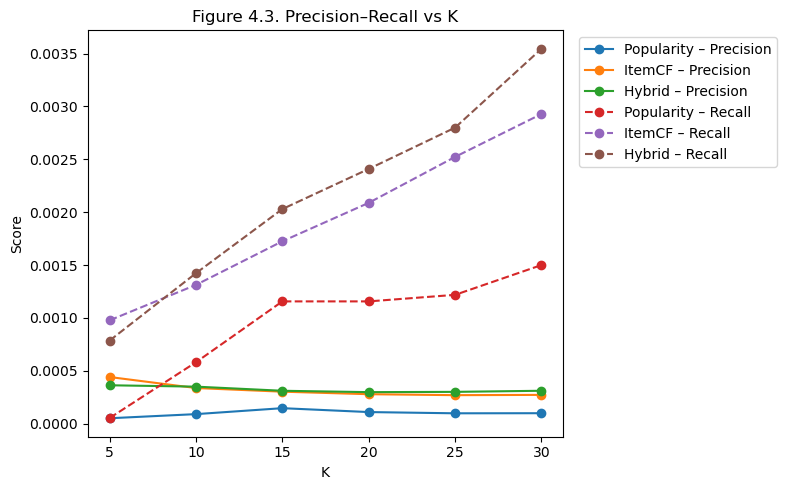

In [421]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _order_models(df):
    pref = ["Popularity", "ItemCF", "Hybrid"]
    seen = df["model"].unique().tolist()
    return [m for m in pref if m in seen] + [m for m in seen if m not in pref]

# ---------- Figure 4.3: Precision–Recall vs K ----------
def plot_precision_recall_vs_k(metrics_df, title="Figure 4.3. Precision–Recall vs K"):
    assert set(["model","K","precision","recall"]).issubset(metrics_df.columns)
    order = _order_models(metrics_df)
    df = metrics_df.copy().sort_values(["model","K"])

    plt.figure(figsize=(8,5))
    # precision
    for m in order:
        sub = df[df["model"]==m]
        plt.plot(sub["K"], sub["precision"], marker="o", label=f"{m} – Precision")
    # recall
    for m in order:
        sub = df[df["model"]==m]
        plt.plot(sub["K"], sub["recall"], marker="o", linestyle="--", label=f"{m} – Recall")

    plt.title(title)
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.xticks(sorted(df["K"].unique()))
    plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()
# ---------- Usage ----------
plot_precision_recall_vs_k(metrics_df)



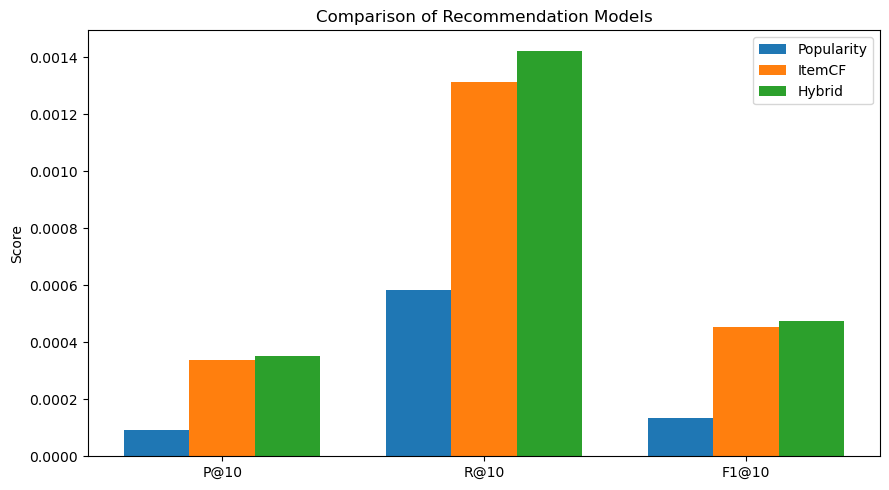

In [506]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = {
    "Model": ["Popularity", "ItemCF", "Hybrid"],
    "P@10": [0.000091, 0.000338, 0.000351],
    "R@10": [0.000582, 0.001313, 0.001424],
    "F1@10": [0.000136, 0.000454, 0.000474],
    "P@20": [0.000110, 0.000279, 0.000299],
    "R@20": [0.001157, 0.002089, 0.002409],
    "F1@20": [0.000183, 0.000440, 0.000475],
    "Coverage": [0.000483, 0.635669, 0.619358],
    "Gini": [0.047371, 0.527596, 0.633023],
    "Novelty": [10.506510, 17461.839553, 11594.168367]
}

df = pd.DataFrame(data)

# Pick metrics to plot (e.g., Coverage, Gini, Novelty)
metrics = ["P@10", "R@10","F1@10"]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(9,5))

for i, model in enumerate(df["Model"]):
    ax.bar(x + i*width, df.loc[i, metrics], width, label=model)

# Add labels
ax.set_ylabel("Score")
ax.set_title("Comparison of Recommendation Models")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()
